# Notebook Context

## Question:
<font size="5">
What is the difference in performance between the UNet++ trained on polar data representation and the UNet++ trained on carthesian data representation?
</font>

## Answer:
<font size="5">
For the UNet++ architecture, training on polar transformation of the data yields a bump in performance of approximately 12% compared to the training performed on the carthesian representation of the data.
</font>


In [4]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from pprint import pprint

# %matplotlib widget

In [5]:
def load_experiment_config(experiment_config_path):
    experiment_config = pkl.load(open(experiment_config_path, "rb"))
    pprint(experiment_config)
    return experiment_config

In [6]:
def load_experiment_data(experiment_data_path):
    experiment_history = pd.read_csv(experiment_data_path, header=0)
    pprint(experiment_history.columns)
    return experiment_history    

In [7]:
def extract_training_coordinates(experiment_config):
    if "polar_training" not in experiment_config["training_config"].keys():
        training_coodinates = "carthesian"
    elif experiment_config["training_config"]["polar_training"]:
        training_coodinates = "polar"
    else:
        training_coodinates = "carthesian"
    
    return training_coodinates

In [8]:
def plot_train_val_metrics(experiment_config, experiment_data, train_metric_names, val_metric_names):
    
    best_metrics = {}
    plt.figure(figsize=(10, 7))
    
    for train_metric_name, val_metric_name in zip(train_metric_names, val_metric_names):
        plt.plot(experiment_data[train_metric_name], label=train_metric_name)
        plt.plot(experiment_data[val_metric_name], label=val_metric_name)
        best_metrics[train_metric_name] = np.round(experiment_data[train_metric_name].max(), 4)
        best_metrics[val_metric_name] = np.round(experiment_data[val_metric_name].max(), 4)

    training_coordinates = extract_training_coordinates(experiment_config)
    
    plt.grid("on")
    start, end = plt.ylim()
    plt.yticks(np.arange(start, end, step=0.02))
    plt.title(f"Model: {experiment_config['training_config']['model']} Transformation: {training_coordinates}")
    plt.xlabel("Training Epochs")
    plt.ylabel("Metric Mangitude")
    plt.legend()
    plt.show()

In [9]:
def plot_cross_experiments_metrics(experiment_configs, experiments_data, metric_names):
    
    plt.figure(figsize=(10, 7))
    dct = {}
    
    for metric_name in metric_names:
        for experiment_config, experiment_data in zip(experiment_configs, experiments_data):
            training_coordinates = extract_training_coordinates(experiment_config)
            plt.plot(experiment_data[metric_name], label=f"{metric_name} - {experiment_config['training_config']['model']} - {training_coordinates}")
            dct[training_coordinates + " " + metric_name] = np.max(experiment_data[metric_name])
    
    col_labels = ["carthesian", "polar"]
    row_labels = metric_names
    table_vals = []
    
    for row_label in row_labels:
        l = []
        for col_label in col_labels:
            l.append(np.round(dct[col_label + " " + row_label], 4))
        table_vals.append(l)

    
    plt.table(
        cellText=table_vals,
        rowLabels = ["best " + label.replace("_", " ") for label in row_labels],
        colLabels = col_labels,
        bbox=[0.7, 0.15, 0.3, 0.1],
        colWidths=[0.1] * 3,
        cellLoc = "center",
        rowLoc="center",
        colLoc="center",
    )

    plt.grid("on")
    start, end = plt.ylim()
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.title(f"Cross-Model Comparison")
    plt.xlabel("Training Epochs")
    plt.ylabel("Metric Mangitude")
    plt.legend(ncol=2)
    plt.show()

In [10]:
def plot_cross_experiments_test_metrics(experiment_configs, experiments_data, metric_names, legend_columns=2):
    
    plt.figure(figsize=(12, 7))
    for metric_name in metric_names:
        for experiment_config, experiment_data in zip(experiment_configs, experiments_data):
            training_coordinates = extract_training_coordinates(experiment_config)
            plt.plot(experiment_data[metric_name], label=f"{metric_name} - {experiment_config['training_config']['model']} - {training_coordinates}")

    plt.grid("on")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(14), experiments_data[0]["volume"], rotation=45)
    plt.title(f"Cross-Model Comparison")
    plt.xlabel("Test Volume")
    plt.ylabel("Metric Mangitude")
    plt.legend(ncol=legend_columns)
    plt.show()

# Lesion Segmentation Training Performance

## Investigate performance of liver tumor segmentation for a UNet++ model

In [11]:
CARTHESIAN_EXPERIMENT_ROOT_PATH = "../experiments_data/set_4_1/experiment_1/"
EXPERIMENT_CONFIG_NAME = "experiment_config.pkl"
EXPERIMENT_HISTORY_NAME = "experiment_history.csv"

# Load experiment config
carthesian_experiment_config = load_experiment_config(os.path.join(CARTHESIAN_EXPERIMENT_ROOT_PATH, EXPERIMENT_CONFIG_NAME))

# Load experiment_history
carthesian_experiment_history = load_experiment_data(os.path.join(CARTHESIAN_EXPERIMENT_ROOT_PATH, EXPERIMENT_HISTORY_NAME))

{'device': 'cuda',
 'training_config': {'Training_ROI_Vicinity': 4,
                     'augment': ['rot', 'zoom', 'hflip', 'vflip'],
                     'batch_size': 32,
                     'class_weights': [1, 1],
                     'crop_size': [256, 256],
                     'data': 'lesion',
                     'gamma': 1,
                     'gpu': 0,
                     'l2_reg': 0,
                     'loss_func': 'multiclass_combined',
                     'lr': 0.001,
                     'model': 'unet_plus_plus',
                     'no_standardize': False,
                     'num_classes': 2,
                     'num_epochs': 50,
                     'num_out_classes': 2,
                     'num_workers': 8,
                     'perc_data': 1,
                     'polar_training': False,
                     'pos_sample_chance': 1,
                     'require_one_hot': True,
                     'seed': 1,
                     'step_size': [30, 60, 90]

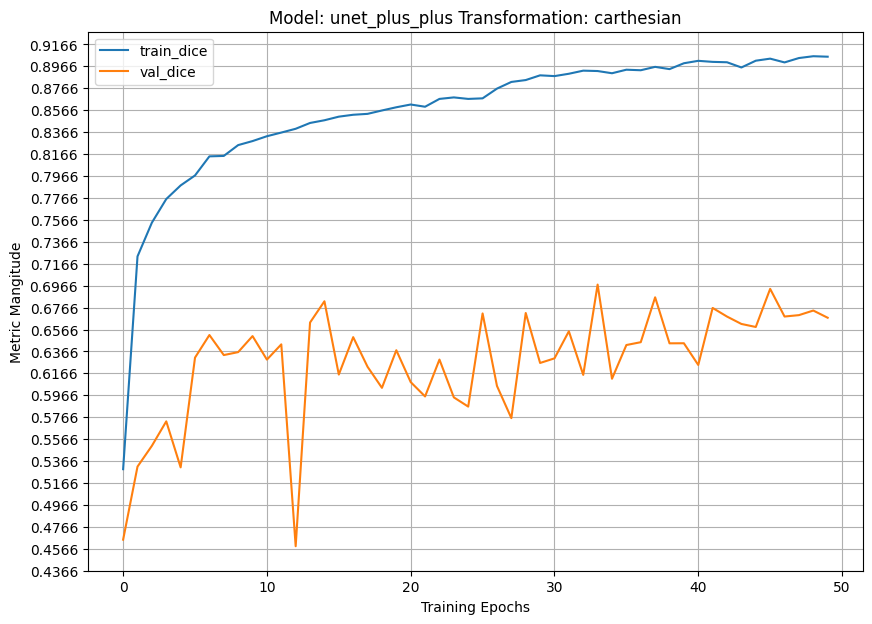

In [12]:
plot_train_val_metrics(
    experiment_config=carthesian_experiment_config,
    experiment_data = carthesian_experiment_history,
    train_metric_names=["train_dice"],
    val_metric_names=["val_dice"]
)

## Cross Experiments

<font size="5">
Compare performance of model trained on carthesian coordinates vs model trained on polar coordinates
</font>

In [13]:
POLAR_EXPERIMENT_ROOT_PATH = "../experiments_data/set_4_1/experiment_2/"

# Load experiment config
polar_experiment_config = load_experiment_config(os.path.join(POLAR_EXPERIMENT_ROOT_PATH, EXPERIMENT_CONFIG_NAME))

# Load experiment_history
polar_experiment_history = load_experiment_data(os.path.join(POLAR_EXPERIMENT_ROOT_PATH, EXPERIMENT_HISTORY_NAME))

{'device': 'cuda',
 'training_config': {'Training_ROI_Vicinity': 4,
                     'augment': ['rot', 'zoom', 'hflip', 'vflip'],
                     'batch_size': 32,
                     'class_weights': [1, 1],
                     'crop_size': [256, 256],
                     'data': 'lesion',
                     'gamma': 1,
                     'gpu': 0,
                     'l2_reg': 0,
                     'loss_func': 'multiclass_combined',
                     'lr': 0.001,
                     'model': 'unet_plus_plus',
                     'no_standardize': False,
                     'num_classes': 2,
                     'num_epochs': 50,
                     'num_out_classes': 2,
                     'num_workers': 8,
                     'perc_data': 1,
                     'polar_training': True,
                     'pos_sample_chance': 1,
                     'require_one_hot': True,
                     'seed': 1,
                     'step_size': [30, 60, 90],

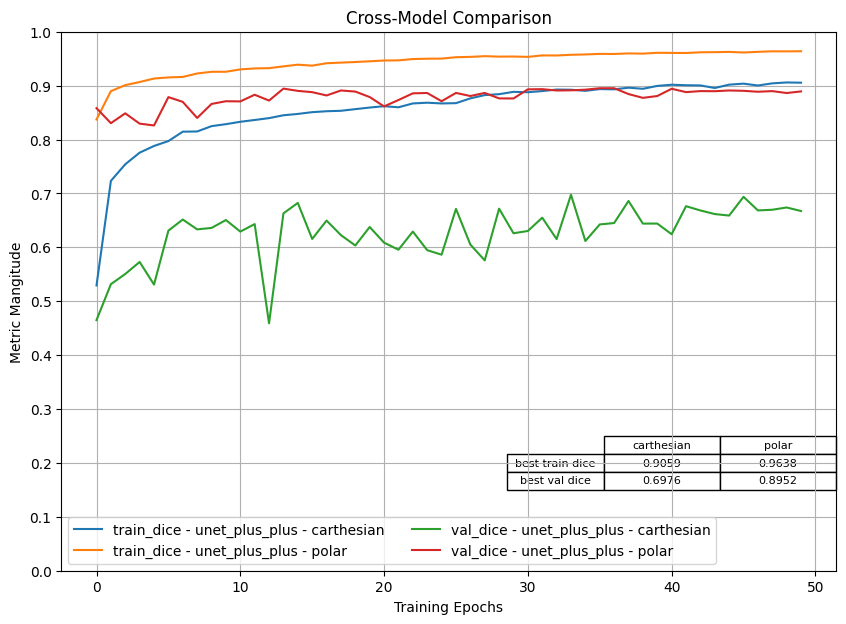

In [14]:
plot_cross_experiments_metrics(
    experiment_configs=[carthesian_experiment_config, polar_experiment_config],
    experiments_data=[carthesian_experiment_history, polar_experiment_history],
    metric_names=["train_dice", "val_dice"]
    )

# Lesion Segmentation Test Performance

In [15]:
TEST_RESULTS_DIRNAME = "test_results_3DIRCADB_Positive_Combined"
TEST_METRICS_FILENAME = "test_metrics.csv"

# carthesian_test_metrics = pd.read_csv(os.path.join(CARTHESIAN_EXPERIMENT_ROOT_PATH, TEST_RESULTS_DIRNAME, TEST_METRICS_FILENAME), header=0)
polar_test_metrics = pd.read_csv(os.path.join(POLAR_EXPERIMENT_ROOT_PATH, TEST_RESULTS_DIRNAME, TEST_METRICS_FILENAME), header=0)

# plot_cross_experiments_test_metrics(
#     experiment_configs=[polar_experiment_config, carthesian_experiment_config],
#     experiments_data=[polar_test_metrics, carthesian_test_metrics],
#     metric_names=["test_dice"],
#     legend_columns=1
#     )

In [18]:
# np.mean(polar_test_metrics["test_auc_score"])
for col in polar_test_metrics.columns[1:]:
    print(f"{col}: {np.mean(polar_test_metrics[col])}")

test_dice: 0.6606960456893087
test_iou: 0.5119132743187974
test_precision: 0.6458571428571428
test_accuracy: 0.9962857142857143
test_recall: 0.7502142857142857
test_specificity: 0.9974285714285714
test_auc_score: 0.4553594219502477
